## The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 3

**Student Name:**    `Yang Song`

**Student ID:**     `1274032`

### 1. Find keypoints and correspondences between two images

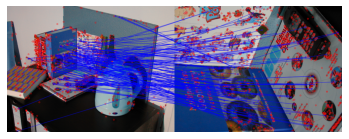

In [3]:
import cv2
import os
from matplotlib import pyplot as plt

def match(img1, img2):
    
    points1 = []
    points2 = []
    
    # use SIFT to detect
    sift = cv2.xfeatures2d.SIFT_create()
    
    # kp=keypoint, des=description
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    # set Flann parameters
    indexParams = dict(algorithm=0, tree=5)
    searchParams = dict(checks=50)
    flann = cv2.FlannBasedMatcher(indexParams, searchParams)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # based on matches generate matchesMast with same length
    matchesMask = [[0, 0] for i in range(len(matches))]
    
    # remove error matches
    for i, (m,n) in enumerate(matches):
        if m.distance <0.7*n.distance:
            matchesMask[i] = [1, 0]
            points1.append(list(kp1[m.queryIdx].pt))
            points2.append(list(kp2[m.trainIdx].pt))
            
    # show the images
    # match lines in blue and keypoints in red
    drawPrams = dict(matchColor=(0, 0, 255),
                    singlePointColor=(255, 0, 0),
                    matchesMask=matchesMask)
    
    match_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **drawPrams)
    
    plt.imshow(match_img)
    plt.axis('off')
    plt.show()
    
    return points1, points2

rootpath = './'
img1 = cv2.imread(os.path.join(rootpath, 'bookshA.png'))
img2 = cv2.imread(os.path.join(rootpath, 'bookshB.png'))

points1, points2 = match(img1, img2)

### 2.a Shift and scale the pixel coordinates

In [7]:
import numpy as np
import copy

def normalise(points):
    avg_x = 0
    avg_y = 0
    # average distance
    for i, (x,y) in enumerate(points):
        avg_x += x
        avg_y += y
    avg_x /= len(points)
    avg_y /= len(points)
    
    scale = 0
    for i, (x,y) in enumerate(points):
        scale += np.sqrt(np.square(points[i][0]-avg_x)+np.square(points[i][1]-avg_y))
    scale /= len(points)
    scale = np.sqrt(2) / scale
    
    T = [[scale, 0, -avg_x*scale], [0, scale, -avg_y*scale], [0, 0, 1]]
    
    for i, (x,y) in enumerate(points):
        points[i][0] = (points[i][0]-avg_x)*scale
        points[i][1] = (points[i][1]-avg_y)*scale
        
    return points, T

points1_a, T1 = normalise(copy.deepcopy(points1))
points2_a, T2 = normalise(copy.deepcopy(points2))

### 2.b Compute the design matrix from sets of 8 points

In [9]:
def matrix(points1, points2):
    ds_matrix = []
    for i in range(8):
        x1 = points1[i][0]
        y1 = points1[i][1]
        x2 = points2[i][0]
        y2 = points2[i][1]
        ds_matrix.append([x2*x1, x2*y1, x2, y2*x1, y2*y1, y2, x1, y1, 1])
    ds_matrix = np.array(ds_matrix)
    
    return ds_matrix

matrix_b = matrix(points1_a, points2_a)

### 2.c Perform an SVD of the design matrix to find its null space (you can use a library function for the SVD)

In [4]:
def null_space(matrix):
    u, s, vt = np.linalg.svd(matrix)
    v = vt[-1]
    
    return v

list_c = null_space(matrix_b)
print(list_c)

[ 0.07612262 -0.03932456  0.38745975 -0.36031229 -0.14592664 -0.75644155
 -0.02892131 -0.03210578  0.34255409]


### 2.d Compose the draft fundamental matrix F

In [11]:
def draft_fundamental(v):
    F = v.reshape(3, 3)
    
    return F

array_d = draft_fundamental(list_c)
print(array_d)

[[ 0.07612262 -0.03932456  0.38745975]
 [-0.36031229 -0.14592664 -0.75644155]
 [-0.02892131 -0.03210578  0.34255409]]


### 2.e Perform an SVD of the draft fundamental matrix, set the smallest singular value to zero and reassemble so that F now has determinant = 0

In [ ]:
def svd_fundamental(F, t1, t2):
    u, s, vt = np.linalg.svd(F)
    s[2] = 0.0
    F0 = np.matmul(np.matmul(u, np.diag(s)), vt)
    
    F0 = np.matmul(np.matmul(t2.T, F0), t1)
    F0 /= F0[2, 2]
    
    return FF

### 2.f Calculate which correspondences are inliers and which are outliers using this F

In [ ]:
def error_fundamental(pt1, pt2, F):
    l = np.matmul(F, pt1)
    ll = l/np.sqrt(np.square(l[0])+np.square(l[1]))
    
    d = np.abs(np.dot(ll, pt2))
    
    return d

### 2.g RANSAC

In [ ]:
def RANSAC(pts1, pts2):
    points_number = 0
    
    pts1_n, T1 = normalize(copy.deepcopy(pts1))
    pts2_n, T2 = normalize(copy.deepcopy(pts2))
    
    best_ratio = 0
    best_F = None
    best_inliers_pair = []
    
    for i in range(5000):
        id = np.random.randint(len(pts1), size=points_number)
        
        while len(set(id)) < len(id):
            id = np.random.randint(len(pts1), size=points_number)
        
        eight_pts1 = []
        eight_pts2 = []
        for i in range(points_number):
            eight_pts1.append(pts1_norm[id[i]])
            eight_pts2.append(pts2_norm[id[i]])
            
        dmatrix = design_matrix(eight_pts1, eight_pts2)
        
        F = draft_fundamental(null_space_eigen(dmatrix))
        F = svd_fundamental(F, T1, T2)
        
        liers = 0
        liers_pair = []
        
        for i in range(len(pts1)):
            pt1 = np.append(pts1[i], [1])
            pt2 = np.append(pts2[i], [1])
            error = error.fundamental(pt1, pt2, F)
            if error <= 5:
                liers += 1
                liers_pair.append([pt1[0:2], pt2[0:2]])
        
        ratio = liers/len(pts1)
        
        if ratio > best_ratio:
            best_ratio = ratio
            best_F = F
            best_inliers_pair = liers_pair
            
        if ratio > 0.9:
            return best_F, best_ratio, best_inliers_pair
    
    return best_F, best_ratio, best_inliers_pair